In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

This is a 3 part series in which I will walk through a dataset analysing it and then at the end do predictive modelling. I recommend to follow the parts in sequential order but you can jump to any part by clicking on the heading links in blue.

**Part 1, Exploratory Data Analysis(EDA):**<br>
This part consists of summary statistics of data but the major focus will be on EDA where we extract meaning/information from data using plots and report important insights about data. This part is more about **data analysis** and **business intelligence(BI)**.

[**Part 2, Statistical Analysis:**](https://www.kaggle.com/gauravsharma99/statistical-analysis-on-mpg-data)<br>
In this part we will do many statistical hypothesis testing, apply estimation statistics and interpret the results we get. We will also validate this with the findings from part one. We will apply both parametric and non-parametric tests. We will report all the important insights we get in this part. This part is all about **data science** requires statistical background.

[**Part 3, Predictive Modelling:**](https://github.com/greatsharma/MPG/tree/master/Modelling)<br>
In this part we will predict some response using predictors. This part is all about **machine learning**.

<span style="color:red">**If you like these notebooks then please upvote and also share with others.**<span>

### Data Description

The data we are using for EDA is the [auto mpg](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset taken from UCI repository.

Information regarding data<br>
&emsp;&emsp;&emsp;&emsp;**Title:** Auto-Mpg Data<br>
&emsp;&emsp;&emsp;&emsp;**Number of Instances:** 398<br>
&emsp;&emsp;&emsp;&emsp;**Number of Attributes:** 9 including the class attribute<br>
&emsp;&emsp;&emsp;&emsp;**Attribute Information:**
    1. mpg:           continuous
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)
    
    All the attributes are self-explanatory.

This data is not complex and is good for analysis as it has a nice blend of both categorical and numerical attributes.

<sup>[data source](https://archive.ics.uci.edu/ml/datasets/auto+mpg)<sup>

This is **part 1** ie., EDA. We won't stretch this part long and do following things in sequential manner.

1. **Preprocess the data**, this includes dealing with missing values, duplicate data if any and then align the data.
2. **EDA on categorical attributes**, this includes analysing their distributions and relations with other cat. attributes.
3. **EDA on numerical attributes**, this includes analysing their distributions and relations with other num. attributes.
4. Then we will analyse the **relation b/w num. & cat. attributes**.

I make use of **seaborn** heavily throughout the notebook, so it is also a good goto notebook for those who are looking for EDA using seaborn.

In [ ]:
# first import all necessary libraries
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# set seaborn's default settings
sns.set() 

    We will first import the data into a pandas dataframe and inspect it's properties.

In [ ]:
df = pd.read_csv("../input/car-mpg/mpg_raw.csv")
df.head()

In [ ]:
# so now the data is in rectangular form with 398 entries each having 9 distinct properties
df.shape

In [ ]:
# let's list all the columns
columns = list(df.columns)
columns

In [ ]:
# we now describe the properties of this dataframe like column datatype etc.
df.info()

We now make two distinct list for categorical and numerical column names as the analysis differ for both the types. For that we introspect the datatypes of each column and if it is of type `object` then it's categorical and else numerical.

We will use these two lists heavily throughout the analysis.

In [ ]:
cats = list(df.select_dtypes(include=['object']).columns)
nums = list(df.select_dtypes(exclude=['object']).columns)
print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

In [ ]:
# let's inspect how many unique values are there in each column.
df.nunique(axis=0)

    As there are very few unique values for cylinders and model_year, so it's safe to make them categorical instead of numeric.

In [ ]:
# cylinders and model_year also seems to be categorical so lets update the lists
cats.extend(['cylinders', 'model_year'])
nums.remove('cylinders')
nums.remove('model_year')

print(f'categorical variables:  {cats}')
print(f'numerical variables:  {nums}')

    Now inspect for nans in data.

In [ ]:
# check for `nans` in each column
df.isna().sum()

In [ ]:
# let's print these 6 `nan` containing rows 
df[df.isnull().any(axis=1)]

In [ ]:
# nan rows proportion in data
6 / len(df)

    So horsepower consists of total of 6 nan rows comprising of around 1.5% of data. As this fraction is very low so it's safe to drop these nan rows for now.

<sup>Note: If the nan-row proportion is large enough then we won't drop it but instead impute missing values.<sup>

In [ ]:
# for now remove all nan rows as they are just 1.5%
df = df[~df.isnull().any(axis=1)]
df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)
df.shape

In [ ]:
# find total duplicate entries and drop them if any
print(f'total duplicate rows: {df.duplicated().sum()}')

# drop duplicate rows if any
df = df[~df.duplicated()]
df.shape

In [ ]:
# before we move ahead it's a good practice to group all variables together having same type.
df = pd.concat((df[cats], df[nums]), axis=1)
df.head()

In [ ]:
num_rows, num_cols = df.shape

In [ ]:
# save this cleaned df to csv
df.to_csv('mpg_cleaned.csv', index=False)

    Now we are all good to go for some in-depth analysis

### Analysis on Categorical Attributes

Our analysis includes both descriptive stats and EDA.

In [ ]:
# let's import the cleaned version of mpg although no need here because we already updated df
df = pd.read_csv("mpg_cleaned.csv")

In [ ]:
print(f'categorical variables:  {cats}')

    We will first slice out the categorical columns from original dataframe and then do analysis on it keeping the original data untou-ched, and at the end incorporate needed changes in our original dataframe.

In [ ]:
df_cat = df.loc[:, 'origin':'model_year']
df_cat.head()

As `origin` and `name` consists of text data so it needs some preprocessing. We will remove all extra spaces from each string, otherwise the same string with different spacings will be treated as different categories which should not be the case.

In [ ]:
# remove extra spaces if any
for col in ['origin', 'name']:
    df_cat[col] = df_cat[col].apply(lambda x: ' '.join(x.split()))

We will create an artificial categorical attribute named `mpg_level` which categorizes `mpg` into `low`, `medium` and `high`. This is done for two reasons, first it will help a lot in EDA i.e., we can bifurcate plots on the basis of mpg and secondly this is easy to understand as compared to numbers in `mpg`.

We are dividing `mpg` into three regions as,<br>
[min, 17) -> low<br>
[17, 29) -> medium<br>
[29, max) -> high

Also the choice of the range is analytical and can be anything till it seems to be reasonable.

<sup>Note: This is feature-engineering and mostly done in predictive modelling but it makes sense to introduce it here.<sup>

In [ ]:
df_cat['mpg_level'] = df['mpg'].apply(lambda x: 'low' if x<17 else 'high' if x>29 else 'medium')
cats.append('mpg_level')
print(f'categorical variables:  {cats}')

In [ ]:
# let's look at the unique categories in `origin`, `cylinders` & `model_year`
# we are leaving `name` because it is almost unique for each entry (nothing interesting)
print(f"categories in origin: {pd.unique(df_cat['origin'])}")
print(f"categories in cylinders: {pd.unique(df_cat['cylinders'])}")
print(f"categories in model_year: {pd.unique(df_cat['model_year'])}")

In [ ]:
# Although descriptive stats for categorical variables are not much informatic but still it's worth looking once.
# Also pandas describe function is only for numeric data and in df_cat `cylinders` & `model_year` are the only numeric type.
df_cat.describe()

    It seems that most of the values in `cylinders` are 4 with a min of 3 and max of 8.

### Analysis of Distribution

Now we analyse the distribution for each categorical feature and make some insights from the plots.

In case of categorical variables an ideal (or atleast loved) distribution is `uniform`, 

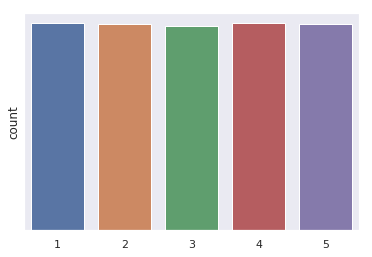

In [ ]:
fig = plt.figure(1, (14, 8))

for i,cat in enumerate(df_cat.drop(['name'], axis=1).columns):
    ax = plt.subplot(2,2,i+1)
    sns.countplot(df_cat[cat], order=df_cat[cat].value_counts().index)
    ax.set_xlabel(None)
    ax.set_title(f'Distribution of {cat}')
    plt.tight_layout()

plt.show()

In [ ]:
# calculate proportion of dominant classes in each category
for i,cat in enumerate(df_cat.drop(['name'], axis=1).columns):
    val_counts = df_cat[cat].value_counts()
    dominant_frac = val_counts.iloc[0] / num_rows
    print(f'`{val_counts.index[0]}` alone contributes to {round(dominant_frac * 100, 2)}% of {cat}')

In [ ]:
# count of different cylinders
df_cat.cylinders.value_counts()

### Insights
* `origin` is highly imbalanced, `usa` alone consists of 62.5% of data whereas `japan` & `europe` are having similar proportion. We will see this dominance in future analysis. `We will try to find the reason for this in our further analysis.`
* `cylinders` is highly imbalanced, `4` alone consists of 50.77% of data. Whereas `8` & `6` are nearly in same proportion but `3` & `5` collectively accounts for only 7 entries i.e., 1.8% of entire data. We will see this huge proportional imbalance in `cylinders` in future analysis.
* `mpg_level` is highly imbalanced, `medium` alone consists of 52.3% of data while `low` & `high` are in the same proportion. This dominance is due the fact of our thresholding while manufacturing this feature because the medium range is broader hence it consists of more data points. It won't be there in original `mpg` feature as it is continous.
* `model_year` is considerably balanced which is good.

    Now we analyse car `name`.

In [ ]:
print(f'total unique categories in `name`: {df_cat.name.nunique()}')
print(f"\nunique categories in `name`:\n\n {df_cat.name.unique()}")

First thing even though name is categorical but it has a lot categories and this even makes sense because product names generally varies a lot in any domain. So it's not fruitfull to do analysis on car names as these are names just like product id and seems to hold no important insights.
    
But one thing to be noticed here is that each car name starts with a company name, so maybe the case that there are very few companies in the dataset and it will be fruitful to extract them as seperate feature and do analysis on that. So let's do it.

We will create a new attribute named as car_company by extracting the first word from all names. We also remove the car company from each car name because it is not needed now, and also we rename column `name` to `car_name`. 

In [ ]:
# extract car company from `name`
df_cat['car_company'] = df_cat['name'].apply(lambda x: x.split()[0])

# remove car company from `name` and rename to `car_name`
df_cat['car_name'] = df_cat['name'].apply(lambda x: ' '.join(x.split()[1:]))
df_cat.drop('name', axis=1, inplace=True)

cats.extend(['car_company', 'car_name'])
cats.remove('name')

print(f'categorical variables:  {cats}')
df_cat.head()

In [ ]:
# now check for total unique values in `car_company`
print(f'total unique categories in `car_company`: {df_cat.car_company.nunique()}')
print(f"\nunique categories in `car_company`:\n\n {df_cat.car_company.unique()}")

    Great this is what we wished and indeed we get. Our idea that there will be few car companies involved in this data is indeed corr-ect. Because the number of categories are less we can now do analysis on that. So we took a step in right direction just by our in-tuition.
    
    Now we analyse the distribution of `car_company`.

In [ ]:
fig = plt.figure(1, (18, 4))

ax1 = plt.subplot(1,1,1)
sns.countplot(df_cat['car_company'], order=df_cat['car_company'].value_counts().index)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=75)

plt.show()

In [ ]:
df_cat.car_company.value_counts()[:2]

### Insights

* We found that `car_name` has a lot categories, close to total data points. So it's not fruitfull to do analysis on that as it is unique for most of the points and also in most cases names are safe to be avoided as they doesn't have correlations with other.
* We then create an artificial attribute named `car_company` by extracting company names from car names. We find that there are much few car companies as compared to car names (around 8 times less).
* We then found that the distribution of `car_company` is not uniform and most of the proportion is covered by top 15 car companies. Whereas `ford` and `chevrolet` alone comprises of around 23% (almost a quater).

### Conclusion

* Every categorical attribute except `model_year` is highly imbalanced and far from `uniform distribution`. In all cases most of the data is comprised of top few categories.
* Although `model_year` is not perfectly uniform but we can think it as `uniform-like distribution`. This is a digestible assumption for two reasons, first we can clearly see in plot that indeed the distribution is `uniform-like` and also this is not the entire population but a sample of it so may be in large run it will converge to `uniform` which may be the true population distribution (**Law of Large Number**).

    Now we will analyze how different features behaves on changing other features.

In [ ]:
combos = itertools.combinations(['origin', 'cylinders', 'mpg_level'], 2)

fig = plt.figure(1, (18, 8))

i = 0
for pair in combos:
#     i+=1
#     ax = plt.subplot(2,3,i)
#     sns.countplot(x=pair[0], hue=pair[1], data=df_cat)
#     ax.set_xlabel(None)
#     ax.set_title(f'{pair[0]} bifurcated by {pair[1]}')
#     plt.tight_layout()

    i+=1
    ax = plt.subplot(2,3,i)
    sns.countplot(x=pair[1], hue=pair[0], data=df_cat)
    ax.set_xlabel(None)
    ax.set_title(f'{pair[1]} bifurcated by {pair[0]}')
    plt.tight_layout()

### Insights
    We can clearly see the inpact of imbalanced categories in our bifurcated plots.

<br>**cylinders bigurcated by origin**
* Japan is the only origin with vehicles having 3 cylinders.
* Europe is the only origin with vehicles having 5 cylinders.
* USA is the only origin with vehicles having 8 cylinders.
* All origins has 4 cylinder vehicles and in almost equal proportion, also because 4 is dominating in cylinders.
* All origins has 6 cylinder vehicles but dominated by USA due the fact that it is dominating in origin.

<br>**mpg_level bigurcated by origin**
* Japan doesn't have any vehicle with low mpg_level whereas europe has negligible vehicles with low mpg_level and almost all vehicles that has low mpg_level are from usa.
* Japan has the most vehicles with high mpg_level.
* USA has the most vehicles with medium mpg_level (again due to the fact that most vehicles belongs to USA).

<br>**mpg_level bigurcated by cylinders**
* Vehicles with low mpg_level has either 6 or 8 cylinders and most of them has 8 cylinders.
* Almost all vehicles with high mpg_level has 4 cylinders and with very few (less than 5) has 5-6 cylinders.
* Most vehicles with medium mpg_level has 4,6 & 8 cylinders. This is due to the fact that most of the vehicles has these number of cylinders as we inspected in cylinder distribution earlier.

        Let's analyse mpg_level with cylinders bifurcated by origin.

In [ ]:
sns.catplot(x='mpg_level', hue='cylinders', col='origin', data=df_cat, kind='count')
plt.show()

### Insights
* Japan doesn't have any cylinder with low mpg_level and most of it's vehicles have high mpg_level with mostly 4 cylinders(this we already inspected from earlier plots as well, nothing new).
* Almost every vehicle in europe has 4 cylinders and most of them are medium or high.
* USA has few vehicles with high mpg level as compared to other knowing the fact that most of the vehicles belongs to USA.

<sup>Note: Although these insights can be detected from earlier plots but it was bit hard and bifurcating helps us and we extracted even more meaning from data.<sup>

### Conclusion
* Japan is leading in case of mpg level with most of it's vehicles having high mpg_level. It has more than twice vehicles with high mpg compared to other origins.
* **It seems like as number of cylinders increases mpg decreases generally.**

    Let's analyse model_year

In [ ]:
fig = plt.figure(1, (18,4))
sns.countplot(x='model_year', hue='mpg_level', data=df_cat)
sns.relplot(x='model_year', y='mpg', data=df)
plt.show()

### Insights

* As year progresses manufacturing of low mpg car decreases and eventually stopped after 79.
* As year progresses manufacturing of high mpg car increases and infact after 79 their manufacturing was 1.5-2 times as compared to vehicles with medium mpg.
* Throughout the years there is no significant change in manufacturing of vehicles with medium mpg and infact from 74-79 their manufacturing was more than the sum of remaining two.
* From the scatter plot we can clearly see an upward linear trend i.e., as year progress mpg increases.

In [ ]:
fig = plt.figure(1, (18,4))
sns.countplot(x='model_year', hue='cylinders', data=df_cat)
plt.show()

### Insights

* As the year progresses vehicles with more cylinders (8 & 6) decreases significantly.
* As the year progresses vehicles with less cylinders increases.
* One important thing to be noticed that throughout the years vehicles with 4 cylinders have significant proportion and infact in the 80's most of the vehicles has 4 cylinders.

    These results make sense because as year progresses technology advances vehicles with low mpg and more cylinders looses focus and vehicles with high mpg and less cylinders are the new stars.

In [ ]:
fig = plt.figure(1, (18,4))
sns.countplot(x='model_year', hue='origin', data=df_cat)
plt.show()

### Insights

* In the starting year manufacturing in USA is dominated compeletely.
* As the year progresses japan and europe started manufacturing more vehicles. Infact in the year 80 both japan and europe manufactured more than USA. This may be due to something because throught the years USA dominates and suddenly there is a considerable decrease in their manufacturing. This may have something to do in USA in year 80.
* Initially europe manufactures more vehicle then japan but then japan exceeds it after 76.

    Let's analyse car_company
    
As `car_company` contains a lot categories and most of them has very low proportion so we will analyse only the top 15 car companies.

In [ ]:
top_car_companies = df_cat.car_company.value_counts()[:15].index
top_car_companies

In [ ]:
df_cat_top_comp = df_cat[df_cat.car_company.isin(top_car_companies)]
df_cat_top_comp.shape

    We can see that top 15 car companies alone manufactures 83% of vehicles.

In [ ]:
fig = plt.figure(1, (18,12))

for i,cat in enumerate(['mpg_level', 'origin', 'cylinders']):
    ax = plt.subplot(3,1,i+1)
    sns.countplot(x='car_company', hue=cat, data=df_cat_top_comp)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
    plt.tight_layout()

### Insights
* Top manufacturing companies have all mpg level vehicles but companies with less vehicles focuses more on high or medium mpg vehicle.
* All top manufacturing companies are from `usa` and that is the reason why usa has most of the vehicles in dataset (this is one of our key findings). We now answered this question asked earlier by us.
* All top manufacturing companies focuses on vehicles with cylinders 4, 6 & 8 equally, but the companies with less manufacturing generally uses less cylinders in their vehicles.

    We are done with the analysis of categorical attributes and found lots of interesting things and answered many unknown questions.  Now we will incorporate the required changes of df_cat into df.
    
Every attribute except `car_name` is of interest and participated in our analysis. So we will not add `car_name` to our dataframe as it is of no interest. This is `feature reduction` and is an integral part of `feature engineering`.

In [ ]:
df = pd.concat((df_cat.loc[:, 'origin':'car_company'], df.loc[:, 'mpg':'acceleration']), axis=1)
df.head()

In [ ]:
# save these changes to new file
df.to_csv("mpg_cated.csv", index=False)

### Analysis on Numerical Attributes

Our analysis includes both descriptive stats and EDA.

In [ ]:
df = pd.read_csv("mpg_cated.csv")
df.head()

In [ ]:
print(f'numerical variables:  {nums}')

    We will first slice out the numerical columns from original dataframe & then do analysis on it keeping the original data untouched,and at the end incorporate needed changes in our original dataframe.

In [ ]:
df_num = df.loc[:, 'mpg':]

    Let's first look at some descriptive stats.

In [ ]:
df_num.describe()

### Analysis of Distribution

Now we analyse the distribution for each numerical attribute and make some insights from the plots.

In case of numerical variables an ideal (or atleast loved) distribution is `gaussian`, for a gaussian it's various distribution plots look like this
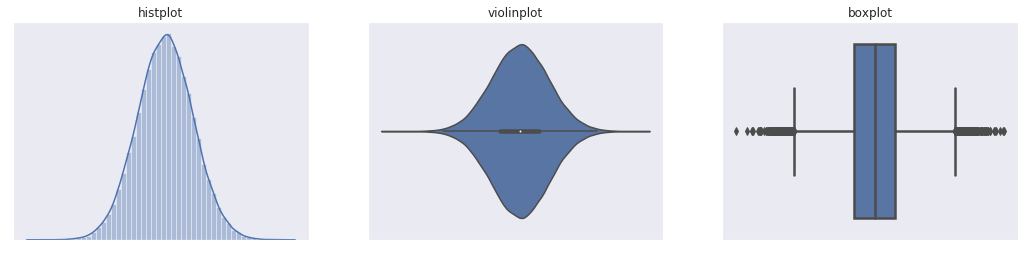

In [ ]:
rows = len(nums)
cols = 3

fig = plt.figure(1, (18, rows*3))

i = 0
for col in nums:
    
    i += 1
    ax1 = plt.subplot(rows, cols,i)
#     ax1.hist(df[col], alpha=0.6)
    sns.distplot(df_num[col])
    ax1.set_xlabel(None)
    ax1.set_title(f'{col} distribution')
    plt.tight_layout()

    i += 1
    ax2 = plt.subplot(rows, cols,i)
    sns.violinplot(df_num[col])
    sns.swarmplot(df_num[col], alpha=0.6, color='k')
    ax2.set_xlabel(None)
    ax2.set_title(f'{col} swarm-violin plot')
    plt.tight_layout()

    i += 1
    ax3 = plt.subplot(rows, cols,i)
    sns.boxplot(df_num[col], orient='h', linewidth=2.5)
    ax3.set_xlabel(None)
    ax3.set_title(f'{col} box plot')
    plt.tight_layout()

### Insights
* `acceleration` is the only distribution which is gaussian. There are few values in acceleration which lie outside the whiskers(the bars extending outwards from the box), these are fliers/outliers.
* distributions of `mpg` & `weight` seems to be `right-skewed gaussian`.
* distributions of `displacement` & `horsepower` seems to be far from gaussian.

Currently we are analysing the distributions just from plots, in the next phase(statistical analysis) we will do hypothesis testing for the normality of these distributions.

    Let's analyse the outliers using tukey formula.

In [ ]:
def tukey_outliers(x):
    q1 = np.percentile(x,25)
    q3 = np.percentile(x,75)
    
    iqr = q3-q1
    
    min_range = q1 - iqr*1.5
    max_range = q3 + iqr*1.5
    
    outliers = x[(x<min_range) | (x>max_range)]
    return outliers

In [ ]:
for col in nums:
    outliers = tukey_outliers(df_num[col])
    if len(outliers):
        print(f"* {col} has these tukey outliers,\n{outliers}\n")
    else:
        print(f"* {col} doesn't have any tukey outliers.\n")

`acceleration` and `horsepower` are the only attributes with tukey outliers and we can also notice this from the above boxplots.

In [ ]:
df.iloc[list(tukey_outliers(df_num.acceleration).index)]

In [ ]:
df.iloc[list(tukey_outliers(df_num.horsepower).index)]

### Insights
* Outliers in acceleration seems to be random nothing conclusive. One thing we can notice that none of them are from japan.
* Outliers in horsepower are not seeming random, there is a lot common in them
    * All of them are from usa (maybe because vehicles from usa are in majority).
    * All of them has 8 cylinders.
    * All of them has low mpg level.
    * All of them has weight in the range 4000.
    * Most of them has displacement in range 400.
    * Most of them were manufactured in early years(before 74).

In [ ]:
# see data is not scaled properly, we need to scale it for modelling but works fine for analysis.
fig = plt.figure(1, (12, 4))
ax = plt.subplot(1,1,1)
sns.boxplot(x="variable", y="value", data=pd.melt(df_num))
plt.xlabel(None)
plt.ylabel(None)
plt.show()

**Now we analyze relationship between different numerical attributes**

In [ ]:
sns.pairplot(data=df, vars=nums, diag_kind='kde', hue='origin',
            plot_kws=dict(s=20, edgecolor="k", linewidth=0.1, alpha=0.5), diag_kws=dict(shade=True))
plt.show()

In [ ]:
sns.heatmap(df_num.corr(method='spearman'), annot = True, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')
plt.show()

### Insights
* as mpg increases displacement, horsepower & weight decreases but acceleration increases.
* as horsepower increases displacement & weight increases but acceleration decreases.
* as weight increases displacement increases but acceleration decreases.
* as acceleration increases displacement decreases.

**So all numerical attributes are related with each other.**

    Now we bifurcate these relationships with different categories.

In [ ]:
'''In this plot we analyze the relationship of horsepower & acceleration
bifurcated by origin, mpg_level & cylinders in a single plot.'''

sns.relplot(x='horsepower', y='acceleration', hue='mpg_level', #style='mpg_level',
            size='cylinders', col='origin', data=df, kind='scatter', sizes=(5, 100), alpha=0.6)
plt.show()

### Insights
* In every region there is a negative relation b/w horsepower & acceleration.
* vehicles with low mpg has low acceleration and high horsepower.
* vehicles with more cylinders has low acceleration and high horsepower.

In [ ]:
'''In this plot we analyze the relationship of weight & horsepower
bifurcated by origin, mpg_level & cylinders in a single plot.'''

sns.relplot(x='weight', y='horsepower', hue='mpg_level', #style='mpg_level',
            size='cylinders', col='origin', data=df, kind='scatter', sizes=(5, 100), alpha=0.6)
plt.show()

### Insights
* In every region there is a positive relation b/w weight & horsepower.
* vehicles with low mpg has high weight & horsepower.
* vehicles with more cylinders has high weight & horsepower.

    on bifurcating we didn't found anything new.

**Now we analyze relationship between numerical and categorical attributes**

<sup>Note: We are using boxen and violin plots for this but we can also use stripplot.<sup>

In [ ]:
print('variation of numerical features with origin')

fig = plt.figure(1, (18, 8))

for idx,col in enumerate(nums):
    ax = plt.subplot(2, 3, idx+1)
    sns.boxenplot(x='origin', y=col, data=df)
    ax.set_xlabel(None)
    plt.tight_layout()

### Insights
* vehicles of `usa` has less mpg on an average as compared to japan & europe.
* vehicles of `usa` has more displacement, horsepower and weight as compared to japan & europe.
* all vehicles has relatively same acceleration irrespective of the origin but distribution of acceleration from `usa` is more spreaded due to the fact that it comprises a lot vehicles compared to other.

In [ ]:
print('variation of numerical features with mpg_level')

fig = plt.figure(1, (18, 8))

for idx,col in enumerate(nums):
    ax = plt.subplot(2, 3, idx+1)
    sns.boxenplot(x='mpg_level', y=col, data=df)
    ax.set_xlabel(None)
    plt.tight_layout()

### Insights
* as mpg_level increases displacement decreases on average.
* as mpg_level increases horsepower decreases on average.
* as mpg_level increases weight decreases on average.
* vehicles with low mpg_level usually has less acceleration compared to other whereas vehicles with medium and high mpg_level has same acceleration.

In [ ]:
print('variation of numerical features with cylinders')

fig = plt.figure(1, (18, 14))

for idx,col in enumerate(nums):
    ax = plt.subplot(3, 2, idx+1)
    sns.boxenplot(x='cylinders', y=col, data=df)
    ax.set_xlabel(None)
    plt.tight_layout()

### Insights
* as cylinders increases from 3 to 4 mpg also increases but on further increasing the cylinders mpg starts decreasing.
* displacement increases in polynomial order as cylinders increases.
* as cylinders increases from 3 to 5 horsepower decreases but on further increasing the cylinders it starts increasing.
* on increasing cylinders vehicle's weight increases on average (very obvious).
* as cylinders increases from 3 to 5 vehicle's acceleration also increases but on further increasing the cylinders it starts decreasing(maybe due to the fact that vehicles with more cylinders have more weight and hence less acceleration).

In [ ]:
print('variation of numerical features with model_year')

fig = plt.figure(1, (18, 14))
# fig.tight_layout()

for idx,col in enumerate(nums):
    ax = plt.subplot(3, 2, idx+1)
    sns.violinplot(x='model_year', y=col, data=df)
    ax.set_xlabel(None)
    plt.tight_layout()

In [ ]:
print('variation of numerical features with model_year bifurcated by origin')

fig = plt.figure(1, (18, 14))
# fig.tight_layout()

for idx,col in enumerate(nums):
    ax = plt.subplot(3, 2, idx+1)
    sns.lineplot(x="model_year", y=col, hue='origin', data=df, err_style='bars')
    ax.set_title(f'change in {col} as year progresses in different regions')
    ax.set_xlabel(None)
    plt.tight_layout()

plt.show()

### Insights
* as year progresses there is an increase in mpg across all origins(this we already observed in analysis on categorical data).
* as year progresses there is a slight decrease in displacement, horsepower & weight of the vehicles belonging to `usa` but there is no significant change in `japan` & `europe`.One thing we can observe is that in the 80's all vehicles have similar displacement because unlike the 70's the distribution is not spread out (i.e., distribution is **short fatty** instead of **tall skiny**).
* throughout the years acceleration remains relatively the same across all regions.

So we are done for now. We did some good amount of EDA and also explored various plotting features provided to us by seaborn. I highly recommend you all to use seaborn because it's easy and simple. Also you can use plotly to contruct all the graphs in this notebook. Plotly plots are not only visually awesome but are also interactive and due to this they take much more memory specially scatter plots (as they need to store every data-point info. to enable intractivity). That's why I didn't included any plotly plots.

In the next part we will do some [**Statistical Analysis**](https://www.kaggle.com/gauravsharma99/statistical-analysis-on-mpg-data).

<span style="color:red">**If you like this notebook then please upvote and also share with others.**<span>